# Лабораторная работа №6. 
## Рекуррентные нейронные сети

**Задание:** ознакомьтесь с практической работой №15. На основе неё постройте нейронную сеть, настроенную на генерации текста по роману А. С. Пушкина ["Капитанская дочка"](https://disk.yandex.ru/d/_8cdWf-purcluQ).

In [15]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Для воспроизводимости результатов
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")

print("\n" + "=" * 60)
print("НАСТРОЙКА GPU (PyTorch)")
print("=" * 60)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")

amp_enabled = device.type == "cuda"
scaler = torch.amp.GradScaler("cuda", enabled=amp_enabled)

if device.type == "cuda":
    print(f"CUDA runtime (torch): {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    major, minor = torch.cuda.get_device_capability(0)
    print(f"Compute capability: {major}.{minor}")

    torch.backends.cudnn.benchmark = True
    print("✓ cuDNN benchmark включён")
    print("✓ AMP (autocast + GradScaler) будет использован")
else:
    print("⚠ GPU не найдены — обучение будет выполняться на CPU")

# Быстрая sanity-проверка (если есть CUDA — прогоняем на GPU)
x = torch.randn(512, 512, device=device)
y = x @ x.t()
print(f"Sanity-check matmul: {y.mean().item():.6f}")
print("=" * 60 + "\n")

PyTorch version: 2.9.1+cu128

НАСТРОЙКА GPU (PyTorch)
Устройство: cuda
CUDA runtime (torch): 12.8
GPU: NVIDIA GeForce RTX 5060 Ti
Compute capability: 12.0
✓ cuDNN benchmark включён
✓ AMP (autocast + GradScaler) будет использован
Sanity-check matmul: 0.960293



## Загрузка и предобработка текста


In [51]:
# Читаем текст из файла
# Пробуем разные кодировки
file_path = 'data/kapitanskaya-dochka.txt'

try:
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    print("Файл успешно прочитан в кодировке UTF-8")
except UnicodeDecodeError:
    try:
        with open(file_path, 'r', encoding='cp1251') as f:
            text = f.read()
        print("Файл успешно прочитан в кодировке CP1251")
    except Exception as e:
        print(f"Ошибка при чтении файла: {e}")

print(f"\nДлина текста: {len(text)} символов")
print(f"Первые 500 символов:\n{text[:500]}")


Файл успешно прочитан в кодировке CP1251

Длина текста: 215492 символов
Первые 500 символов:
Александр Сергеевич Пушкин 
Капитанская дочка
     
     
    Береги честь смолоду.
    Пословица
     
ГЛАВА I. СЕРЖАНТ ГВАРДИИ.
     
    - Был бы гвардии он завтра ж капитан.
    - Того не надобно; пусть в армии послужит.
    - Изрядно сказано! пускай его потужит...
    - Да кто его отец?
    - Княжнин.
     
     
     Отец мой Андрей Петрович Гринев в молодости своей служил при графе Минихе, и вышел в отставку премьер-майором в 17.. году. С тех пор жил он в своей Симбирской деревни, где и ж


In [52]:
# Предобработка текста: оставляем только русские буквы, пробелы и основные знаки препинания
import re

# Очищаем текст от лишних символов, оставляем русские буквы, пробелы и основные знаки препинания
text = re.sub(r'[^\u0400-\u04FF\u0020\u000A\u000D\u0021-\u002F\u003A-\u0040\u005B-\u0060\u007B-\u007E]', ' ', text)
# Удаляем множественные пробелы
text = re.sub(r'\s+', ' ', text)
text = text.strip()

print(f"Длина очищенного текста: {len(text)} символов")
print(f"Уникальных символов: {len(set(text))}")
print(f"\nПервые 500 символов очищенного текста:\n{text[:500]}")


Длина очищенного текста: 211562 символов
Уникальных символов: 77

Первые 500 символов очищенного текста:
Александр Сергеевич Пушкин Капитанская дочка Береги честь смолоду. Пословица ГЛАВА . СЕРЖАНТ ГВАРДИИ. - Был бы гвардии он завтра ж капитан. - Того не надобно; пусть в армии послужит. - Изрядно сказано! пускай его потужит... - Да кто его отец? - Княжнин. Отец мой Андрей Петрович Гринев в молодости своей служил при графе Минихе, и вышел в отставку премьер-майором в .. году. С тех пор жил он в своей Симбирской деревни, где и женился на девице Авдотьи Васильевне Ю., дочери бедного тамошнего дворянин


## Подготовка данных для обучения


In [53]:
# Создаём словари для кодирования символов
chars = sorted(list(set(text)))
print(f"Всего уникальных символов: {len(chars)}")

# Словари для преобразования символ <-> индекс
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

print(f"Примеры символов: {chars[:20]}...")
print(f"Размер словаря: {len(char_to_idx)}")


Всего уникальных символов: 77
Примеры символов: [' ', '!', '"', '(', ')', '*', ',', '-', '.', ':', ';', '>', '?', 'Ј', 'А', 'Б', 'В', 'Г', 'Д', 'Е']...
Размер словаря: 77


In [19]:
# Параметры для обучения
SEQUENCE_LENGTH = 100  # Длина последовательности символов для обучения
STEP = 3  # Шаг для создания последовательностей (меньше = больше данных)

# Вместо one-hot будем работать с индексами символов (быстрее и экономит память)
text_indices = np.fromiter((char_to_idx[c] for c in text), dtype=np.int64, count=len(text))

# Индексы начала каждой обучающей последовательности
start_positions = np.arange(0, len(text_indices) - SEQUENCE_LENGTH - 1, STEP, dtype=np.int64)

print(f"Создано последовательностей: {len(start_positions)}")
example_start = int(start_positions[0])
print(
    f"Пример последовательности:\n'{text[example_start:example_start + SEQUENCE_LENGTH]}' -> '{text[example_start + SEQUENCE_LENGTH]}'"
)


Создано последовательностей: 70487
Пример последовательности:
'Александр Сергеевич Пушкин Капитанская дочка Береги честь смолоду. Пословица ГЛАВА . СЕРЖАНТ ГВАРДИИ' -> '.'


In [20]:
# Dataset/DataLoader (индексы вместо one-hot)
class CharDataset(Dataset):
    def __init__(self, text_indices: np.ndarray, start_positions: np.ndarray, seq_len: int):
        self.text_indices = text_indices
        self.start_positions = start_positions
        self.seq_len = seq_len

    def __len__(self):
        return int(self.start_positions.shape[0])

    def __getitem__(self, idx: int):
        s = int(self.start_positions[idx])
        x = self.text_indices[s : s + self.seq_len].copy()
        y = int(self.text_indices[s + self.seq_len])
        return torch.from_numpy(x).long(), torch.tensor(y, dtype=torch.long)


dataset = CharDataset(text_indices, start_positions, SEQUENCE_LENGTH)

BATCH_SIZE = 256 if device.type == "cuda" else 128
print(f"Используется batch_size: {BATCH_SIZE}")

train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

# sanity batch
xb, yb = next(iter(train_loader))
print("Batch X shape:", tuple(xb.shape), "dtype:", xb.dtype)
print("Batch y shape:", tuple(yb.shape), "dtype:", yb.dtype)
print("Vocab size:", len(chars))


Используется batch_size: 256
Batch X shape: (256, 100) dtype: torch.int64
Batch y shape: (256,) dtype: torch.int64
Vocab size: 77


## Построение модели LSTM


In [21]:
# Построение модели LSTM на PyTorch (Embedding + 2-layer LSTM)
VOCAB_SIZE = len(chars)
EMBED_DIM = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 3
DROPOUT = 0.3


class CharLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, hidden_size: int, num_layers: int, dropout: float):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x: torch.Tensor, hidden=None):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        last = self.dropout(out[:, -1, :])
        logits = self.fc(last)
        return logits, hidden


model = CharLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-7
)

print(model)
print("Параметров:", sum(p.numel() for p in model.parameters()))

# sanity forward
model.eval()
with torch.no_grad():
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    logits, _ = model(xb)
    print("Logits shape:", tuple(logits.shape))

"""
# Старый вариант (Keras/TensorFlow) — оставлен в ноутбуке как текст, но НЕ используется
# Создаём модель LSTM с оптимизацией для GPU
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(chars))),
    layers.Dropout(0.2),
    layers.LSTM(128, return_sequences=False),
    layers.Dropout(0.2),
    # Последний слой должен быть float32 для mixed precision
    layers.Dense(len(chars), activation='softmax', dtype='float32')
])

# Компиляция с оптимизацией для GPU
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Для mixed precision используем специальный loss scaling
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
if gpu_available:
    try:
        # Проверяем, включён ли mixed precision
        policy = tf.keras.mixed_precision.global_policy()
        if hasattr(policy, 'name') and policy.name == 'mixed_float16':
            optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)
            print("✓ Используется LossScaleOptimizer для mixed precision")
    except Exception as e:
        print(f"Примечание: {e}")

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()
"""


CharLSTM(
  (embedding): Embedding(77, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=77, bias=True)
)
Параметров: 378381


Traceback (most recent call last):
  File "/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/shutil.py", line 763, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/ds/anaconda3/envs/volsu-mmad/lib/python3.11/shutil.py", line 761, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-oyap79xc'


Logits shape: (256, 77)


'\n# Старый вариант (Keras/TensorFlow) — оставлен в ноутбуке как текст, но НЕ используется\n# Создаём модель LSTM с оптимизацией для GPU\nmodel = keras.Sequential([\n    layers.LSTM(128, return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(chars))),\n    layers.Dropout(0.2),\n    layers.LSTM(128, return_sequences=False),\n    layers.Dropout(0.2),\n    # Последний слой должен быть float32 для mixed precision\n    layers.Dense(len(chars), activation=\'softmax\', dtype=\'float32\')\n])\n\n# Компиляция с оптимизацией для GPU\noptimizer = keras.optimizers.Adam(learning_rate=0.001)\n\n# Для mixed precision используем специальный loss scaling\ngpu_available = len(tf.config.list_physical_devices(\'GPU\')) > 0\nif gpu_available:\n    try:\n        # Проверяем, включён ли mixed precision\n        policy = tf.keras.mixed_precision.global_policy()\n        if hasattr(policy, \'name\') and policy.name == \'mixed_float16\':\n            optimizer = keras.mixed_precision.LossScaleOptimizer(optimi

## Обучение модели


In [22]:
# Генерация текста на PyTorch (temperature sampling)

def _safe_char_idx(ch: str) -> int:
    if ch in char_to_idx:
        return int(char_to_idx[ch])
    return int(char_to_idx.get(' ', 0))


def sample_from_logits(logits: torch.Tensor, temperature: float = 1.0) -> int:
    temperature = float(max(1e-4, temperature))
    probs = torch.softmax(logits.float() / temperature, dim=-1)
    return int(torch.multinomial(probs, 1).item())


@torch.no_grad()
def generate_text(model: nn.Module, seed_text: str, length: int = 400, temperature: float = 1.0) -> str:
    model.eval()

    seed = seed_text[-SEQUENCE_LENGTH:]
    x = torch.tensor([_safe_char_idx(c) for c in seed], device=device).unsqueeze(0)  # (1, T)

    logits, hidden = model(x, hidden=None)

    generated = seed_text
    next_idx = sample_from_logits(logits[0], temperature)
    generated += idx_to_char[next_idx]

    inp = torch.tensor([[next_idx]], device=device)
    for _ in range(length - 1):
        logits, hidden = model(inp, hidden)
        next_idx = sample_from_logits(logits[0], temperature)
        generated += idx_to_char[next_idx]
        inp = torch.tensor([[next_idx]], device=device)

    return generated

'''
# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется
# Функция для генерации текста на основе модели
def sample(preds, temperature=1.0):
    """Сэмплирует индекс символа из массива вероятностей"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, seed_text, length=400, temperature=1.0):
    """Генерирует текст заданной длины на основе начальной последовательности"""
    generated = seed_text
    # Используем predict_on_batch для более эффективной работы с GPU
    use_batch = len(tf.config.list_physical_devices('GPU')) > 0
    
    for _ in range(length):
        # Подготавливаем входную последовательность
        x_pred = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
        for t, char in enumerate(seed_text[-SEQUENCE_LENGTH:]):
            if char in char_to_idx:
                x_pred[0, t, char_to_idx[char]] = 1
        
        # Получаем предсказание (оптимизировано для GPU)
        if use_batch:
            # Используем predict_on_batch для GPU
            preds = model.predict_on_batch(x_pred)[0]
        else:
            # Обычный predict для CPU
            preds = model.predict(x_pred, verbose=0)[0]
        
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]
        
        generated += next_char
        seed_text = seed_text[1:] + next_char
    
    return generated
'''


'\n# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется\n# Функция для генерации текста на основе модели\ndef sample(preds, temperature=1.0):\n    """Сэмплирует индекс символа из массива вероятностей"""\n    preds = np.asarray(preds).astype(\'float64\')\n    preds = np.log(preds + 1e-8) / temperature\n    exp_preds = np.exp(preds)\n    preds = exp_preds / np.sum(exp_preds)\n    probas = np.random.multinomial(1, preds, 1)\n    return np.argmax(probas)\n\ndef generate_text(model, seed_text, length=400, temperature=1.0):\n    """Генерирует текст заданной длины на основе начальной последовательности"""\n    generated = seed_text\n    # Используем predict_on_batch для более эффективной работы с GPU\n    use_batch = len(tf.config.list_physical_devices(\'GPU\')) > 0\n\n    for _ in range(length):\n        # Подготавливаем входную последовательность\n        x_pred = np.zeros((1, SEQUENCE_LENGTH, len(chars)))\n        for t, char in enumerate(seed_text[-SEQUENCE_LENGTH:

In [23]:
# Подготовка seed-текста и функция для вывода примера генерации (PyTorch)
start_idx = np.random.randint(0, len(text) - SEQUENCE_LENGTH - 1)
seed_text = text[start_idx : start_idx + SEQUENCE_LENGTH]
print(f"Начальная последовательность для генерации:\n'{seed_text}'")

@torch.no_grad()
def print_generation_example(epoch: int, temperature: float = 0.8, length: int = 200):
    print(f"\n--- После эпохи {epoch} ---")
    print(generate_text(model, seed_text, length=length, temperature=temperature))
    print()

'''
# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется
# Колбэк для вывода примеров генерации во время обучения
class TextGeneratorCallback(keras.callbacks.Callback):
    def __init__(self, seed_text):
        self.seed_text = seed_text
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:  # Каждые 5 эпох
            print(f"\n--- После эпохи {epoch + 1} ---")
            generated = generate_text(self.model, self.seed_text, length=200, temperature=0.8)
            print(generated)
            print()
# Выбираем случайную начальную последовательность
start_idx = np.random.randint(0, len(text) - SEQUENCE_LENGTH - 1)
seed_text = text[start_idx:start_idx + SEQUENCE_LENGTH]
print(f"Начальная последовательность для генерации:\n'{seed_text}'")

'''


Начальная последовательность для генерации:
' чем состояло дело: "Теперь, господа", - продолжал он, - "надлежит решить, как нам действовать проти'


'\n# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется\n# Колбэк для вывода примеров генерации во время обучения\nclass TextGeneratorCallback(keras.callbacks.Callback):\n    def __init__(self, seed_text):\n        self.seed_text = seed_text\n\n    def on_epoch_end(self, epoch, logs=None):\n        if (epoch + 1) % 5 == 0:  # Каждые 5 эпох\n            print(f"\n--- После эпохи {epoch + 1} ---")\n            generated = generate_text(self.model, self.seed_text, length=200, temperature=0.8)\n            print(generated)\n            print()\n# Выбираем случайную начальную последовательность\nstart_idx = np.random.randint(0, len(text) - SEQUENCE_LENGTH - 1)\nseed_text = text[start_idx:start_idx + SEQUENCE_LENGTH]\nprint(f"Начальная последовательность для генерации:\n\'{seed_text}\'")\n\n'

In [24]:
# Обучение модели (PyTorch)
os.makedirs("models", exist_ok=True)
best_path = os.path.join("models", "best_lstm_model.pt")

EPOCHS = 100
patience = 5
best_loss = float("inf")
bad_epochs = 0

history = {"loss": [], "accuracy": []}

print("\nНачинаем обучение...")
for epoch in range(1, EPOCHS + 1):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=amp_enabled):
            logits, _ = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        correct += (logits.argmax(dim=1) == yb).sum().item()
        total += bs

    epoch_loss = running_loss / max(1, total)
    epoch_acc = correct / max(1, total)

    history["loss"].append(epoch_loss)
    history["accuracy"].append(epoch_acc)

    scheduler.step(epoch_loss)

    print(f"Epoch {epoch:02d}/{EPOCHS} | loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

    if epoch % 5 == 0:
        print_generation_example(epoch, temperature=0.8, length=200)

    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        bad_epochs = 0
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "loss": epoch_loss,
                "config": {
                    "vocab_size": VOCAB_SIZE,
                    "embed_dim": EMBED_DIM,
                    "hidden_size": HIDDEN_SIZE,
                    "num_layers": NUM_LAYERS,
                    "dropout": DROPOUT,
                    "sequence_length": SEQUENCE_LENGTH,
                },
            },
            best_path,
        )
        print(f"  ✓ Сохранён лучший чекпоинт: {best_path}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"  ✓ EarlyStopping: нет улучшений {patience} эпох подряд")
            break

# Загружаем лучший чекпоинт
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    print(f"\nЛучший чекпоинт загружен (loss={ckpt.get('loss', None)}): {best_path}")

'''
# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется
# Обучаем модель с оптимизацией для GPU
EPOCHS = 30
# Увеличиваем batch_size для GPU (если есть GPU)
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
BATCH_SIZE = 256 if gpu_available else 128
print(f"Используется batch_size: {BATCH_SIZE}")

# Добавляем callbacks для оптимизации
callbacks = [
    TextGeneratorCallback(seed_text),
    # Сохранение лучшей модели
    keras.callbacks.ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='loss',
        save_best_only=True,
        verbose=1
    ),
    # Уменьшение learning rate при застое
    keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    # Ранняя остановка
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("\nНачинаем обучение...")
history = model.fit(
    X, y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
'''



Начинаем обучение...


Epoch 01/100 | loss=3.3494 acc=0.1531
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 02/100 | loss=3.0931 acc=0.1851
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 03/100 | loss=2.7737 acc=0.2260
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 04/100 | loss=2.6301 acc=0.2464
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 05/100 | loss=2.5491 acc=0.2689

--- После эпохи 5 ---
 чем состояло дело: "Теперь, господа", - продолжал он, - "надлежит решить, как нам действовать протисели мар выванем" Я толу нула, побрыга пжалеву клопена, и на чрот не моши. - востте и бозрезгорежол бамявоть нагисо осроть тамасива вагтех, несь зи я нала ысил гологел патамссвил увренелу етдирнаши по

  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 06/100 | loss=2.4889 acc=0.2814
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 07/100 | loss=2.4368 acc=0.2958
  ✓ Сохранён лучший чекпоинт: models/best_lstm_model.pt
Epoch 08/100 | lo

'\n# Старый вариант (Keras/TensorFlow) — оставлен как текст, но НЕ используется\n# Обучаем модель с оптимизацией для GPU\nEPOCHS = 30\n# Увеличиваем batch_size для GPU (если есть GPU)\ngpu_available = len(tf.config.list_physical_devices(\'GPU\')) > 0\nBATCH_SIZE = 256 if gpu_available else 128\nprint(f"Используется batch_size: {BATCH_SIZE}")\n\n# Добавляем callbacks для оптимизации\ncallbacks = [\n    TextGeneratorCallback(seed_text),\n    # Сохранение лучшей модели\n    keras.callbacks.ModelCheckpoint(\n        \'best_lstm_model.h5\',\n        monitor=\'loss\',\n        save_best_only=True,\n        verbose=1\n    ),\n    # Уменьшение learning rate при застое\n    keras.callbacks.ReduceLROnPlateau(\n        monitor=\'loss\',\n        factor=0.5,\n        patience=3,\n        min_lr=1e-7,\n        verbose=1\n    ),\n    # Ранняя остановка\n    keras.callbacks.EarlyStopping(\n        monitor=\'loss\',\n        patience=5,\n        restore_best_weights=True,\n        verbose=1\n    )\n]\

## Визуализация процесса обучения


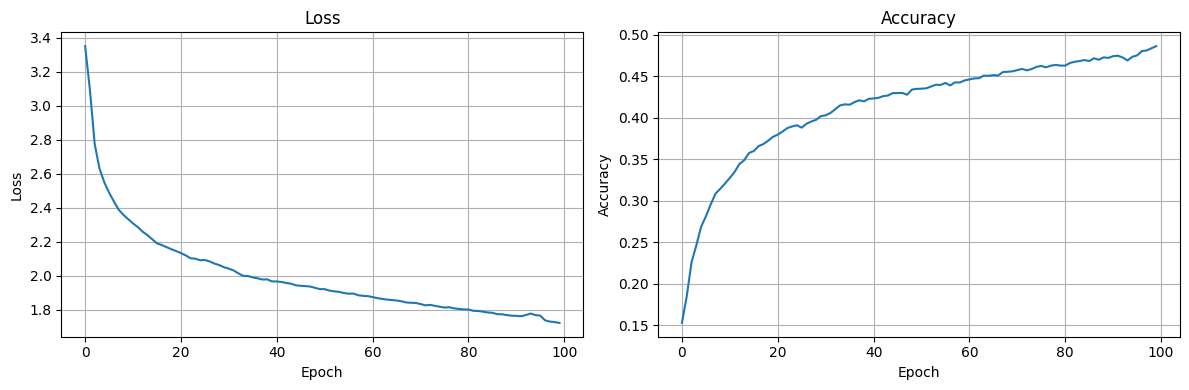

In [25]:
# Графики обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


## Генерация текста


In [26]:
# Генерируем текст с разными температурами
print("=" * 80)
print("ГЕНЕРАЦИЯ ТЕКСТА")
print("=" * 80)

# Выбираем новую начальную последовательность
start_idx = np.random.randint(0, len(text) - SEQUENCE_LENGTH - 1)
seed = text[start_idx:start_idx + SEQUENCE_LENGTH]
print(f"\nНачальная последовательность:\n'{seed}'\n")

# Разные температуры влияют на креативность текста
temperatures = [0.5, 0.8, 1.0, 1.2]

for temp in temperatures:
    print(f"\n{'='*80}")
    print(f"Температура: {temp} (ниже = более консервативно, выше = более креативно)")
    print(f"{'='*80}")
    generated = generate_text(model, seed, length=400, temperature=temp)
    print(generated)
    print()


ГЕНЕРАЦИЯ ТЕКСТА

Начальная последовательность:
' любезной! Пугачев не знал, что она была дочь капитана Миронова; озлобленный Швабрин мог открыть ему'


Температура: 0.5 (ниже = более консервативно, выше = более креативно)
 любезной! Пугачев не знал, что она была дочь капитана Миронова; озлобленный Швабрин мог открыть ему привести в казну ужашну от на судушкай, и привести под был и как службы богу стариками. - "Отвези в нему смотрился овинить к тому дому угоровились его в сотеренданному собешьем. Я отвечал на своего не коменданта, не поминитию мне уж воротил, что не и так посветили, самой доброго послел я так ворода. Я полинула на своем оставаться с моглу отвечал, и меня он не было проидного слубовился от толучая 


Температура: 0.8 (ниже = более консервативно, выше = более креативно)
 любезной! Пугачев не знал, что она была дочь капитана Миронова; озлобленный Швабрин мог открыть ему и седел на врезали ударноваясь, по самоком такатьскую было прастивном поелей лабить. С она, и к выпости

In [27]:
# Сохраняем модель
import pickle

# Создаём директорию для моделей, если её нет
os.makedirs('models', exist_ok=True)

# Сохраняем модель
model.save('models/lstm_text_generator.h5')
print("Модель сохранена в 'models/lstm_text_generator.h5'")

# Сохраняем словари
with open('models/char_to_idx.pkl', 'wb') as f:
    pickle.dump(char_to_idx, f)
with open('models/idx_to_char.pkl', 'wb') as f:
    pickle.dump(idx_to_char, f)
print("Словари сохранены")


AttributeError: 'CharLSTM' object has no attribute 'save'